In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
from matplotlib import rcParams,font_manager
from matplotlib.ticker import FormatStrFormatter

%load_ext autoreload
%autoreload 2

In [2]:
rcParams['figure.figsize'] = (6,6) #figure size in inches
rcParams['font.family'] = "sans-serif" 
rcParams['font.weight'] = "roman" 
rcParams['font.style'] = "normal" # not 100% sure what this does but it was recommended
rcParams['font.size'] = 32 # not 100% sure what this does but it was recommended
rcParams['pdf.fonttype'] = 42
rcParams['axes.linewidth'] = 2 #thickness of the border
rcParams['xtick.major.width'] = rcParams['axes.linewidth'] # make sure line widths are consistent
rcParams['ytick.major.width'] = rcParams['axes.linewidth']
rcParams['axes.spines.right'] = False #hides right border
rcParams['axes.spines.top'] = False #hides top
rcParams['legend.frameon'] = False #hides box around the legend
rcParams['legend.fontsize'] = 18 #font size in pt
rcParams['axes.labelsize'] = 32 
rcParams['xtick.labelsize'] = 24
rcParams['ytick.labelsize'] = rcParams['xtick.labelsize']
rcParams['lines.linewidth'] = 3
rcParams['xtick.major.size'] = 5
rcParams['lines.markersize'] = 16
rcParams['ytick.major.size'] = rcParams['xtick.major.size'] 
#rcParams['text.usetex'] = True
#rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command

In [3]:
direc = 'C:/Users/svo/Google Drive/Bas Games/Analysis/'
fig_direc = 'C:/Users/svo/Google Drive/Bas Games/Figures/'

In [4]:
lesions = ['final_noprune','final_notree','final_nodelta','final_noact','final_nocenter',
          'final_no2conn','final_no2unc','final_no3','final_no4']
j = [0,1,2,4,5,6,7,8,9]

param_names = [r'$\theta$',r'$\gamma$',r'$\delta$',r'$C$',r'$w_{\text{center}}$',
               r'$w_{\text{connected 2-in-a-row}}$',r'$w_{\text{unconnected 2-in-a-row}}$',
              r'$w_{\text{3-in-a-row}}$',r'$w_{\text{4-in-a-row}}$']

time_colors = ['#9F4AB0','#6E207D','#430F4D']
learn_colors = ['#7DE3AC', '#0EE676', '#129951','#17452D','#20382B']
peak_colors = ['#D7E8FA','#A3CDF7','#3C92E8','#0E5296','#0F3153']

Nparams = len(param_names)

def ave_across_splits(p):
    return np.nanmean(np.reshape(p,[int(p.shape[0]/5),5,int(p.shape[1])]),axis=1)

def shrink_input(p):
    return np.column_stack([p[:,[1,2,41,3]],np.nanmean(p[:,24:28]/p[:,7:11],axis=1),p[:,6:11]])


In [5]:
Pfull = ave_across_splits(shrink_input(np.loadtxt(direc + 'Params/params_hvh_final.txt')))

Plesions=[ave_across_splits(shrink_input(np.loadtxt(direc + 'Params/params_hvh_' + m + '.txt')))
             for m in lesions]

C:\Users\svo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


In [6]:
np.mean(Pfull,axis=0)

array([4.936233  , 0.0217952 , 0.22094454, 0.02134452, 0.92497526,
       0.60912862, 0.90444204, 0.45075576, 3.4271775 , 6.172805  ])

In [7]:
c1 = np.vstack([[sts.pearsonr(Pfull[:,j[k]]-Plesions[i][:,j[k]],Pfull[:,j[i]])[0] 
                for i in range(9)] for k in range(9)])
p1 = np.vstack([[sts.pearsonr(Pfull[:,j[k]]-Plesions[i][:,j[k]],Pfull[:,j[i]])[1] 
                for i in range(9)] for k in range(9)])

D = np.vstack([[sts.ks_2samp(Plesions[i][:,j[k]],Pfull[:,j[k]])[0]
                for i in range(9)] for k in range(9)])
p3 = np.vstack([[sts.ks_2samp(Plesions[i][:,j[k]],Pfull[:,j[k]])[1]
                for i in range(9)] for k in range(9)])

In [8]:
D

array([[1.   , 1.   , 0.125, 0.15 , 0.2  , 0.3  , 0.15 , 0.475, 0.65 ],
       [0.125, 1.   , 0.25 , 0.125, 0.225, 0.275, 0.15 , 0.35 , 0.2  ],
       [0.1  , 0.375, 1.   , 0.15 , 0.2  , 0.125, 0.175, 0.425, 0.225],
       [0.225, 0.7  , 0.4  , 0.725, 0.2  , 0.375, 0.125, 0.475, 0.25 ],
       [0.15 , 0.125, 0.125, 0.1  , 0.95 , 0.325, 0.175, 0.1  , 0.075],
       [0.15 , 0.3  , 0.225, 0.225, 0.15 , 0.975, 0.15 , 0.625, 0.125],
       [0.1  , 0.425, 0.125, 0.1  , 0.1  , 0.325, 1.   , 0.125, 0.175],
       [0.225, 0.4  , 0.425, 0.275, 0.325, 0.3  , 0.125, 1.   , 0.2  ],
       [0.475, 0.575, 0.3  , 0.125, 0.125, 0.125, 0.2  , 0.325, 0.925]])

In [9]:
D[7,2],p3[7,2]

(0.425, 0.0012708143485281624)

In [10]:
D[2,7],p3[2,7]

(0.425, 0.0012708143485281624)

In [11]:
c1[7,2],p1[7,2]

(0.07903490837411394, 0.6278397939464524)

$\delta$ $w_{\text{3-in-a-row}}$


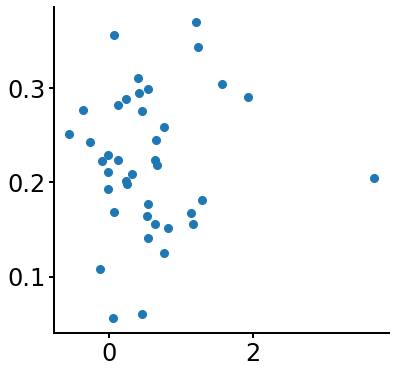

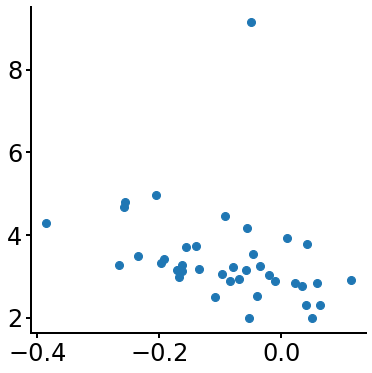

In [12]:
i = 2
k = 7
print(param_names[i],param_names[k])
plt.plot(Pfull[:,j[k]]-Plesions[i][:,j[k]],Pfull[:,j[i]],'.')
plt.show()

plt.plot(Pfull[:,j[i]]-Plesions[k][:,j[i]],Pfull[:,j[k]],'.')
plt.show()

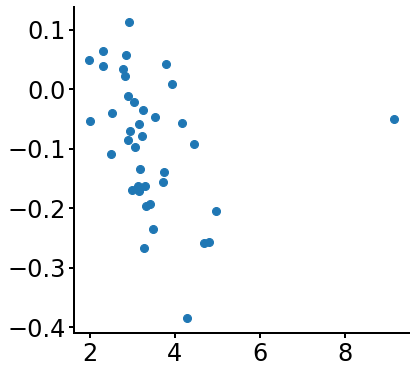

In [13]:
plt.plot(Pfull[:,8]-Plesions[7][:,8],Pfull[:,2]-Plesions[7][:,2],'.')
#plt.xlabel('Feature drop rate')
#plt.legend()
plt.show()

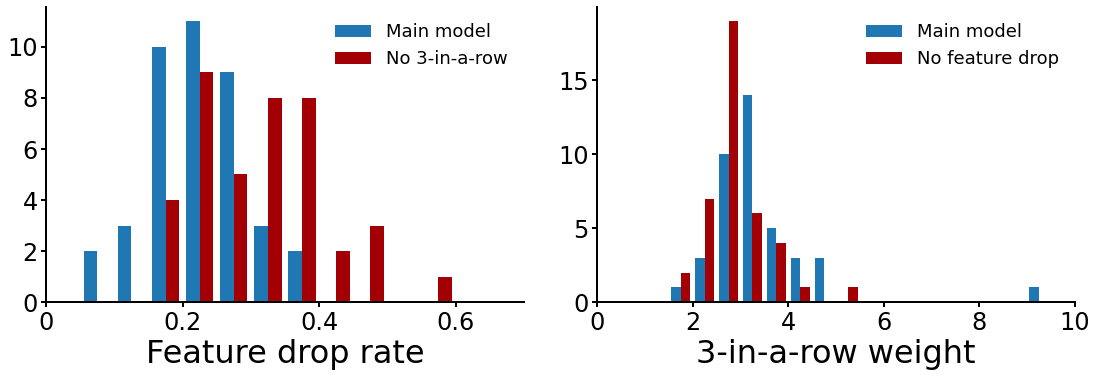

In [14]:
fig,axes = plt.subplots(1,2,figsize=(16,6))

axes[0].xaxis.set_major_formatter(FormatStrFormatter('%g'))

axes[0].hist([Pfull[:,2],Plesions[7][:,2]],label=['Main model','No 3-in-a-row'],bins=np.arange(0,0.75,0.05),color=['C0','#A30006'])
axes[0].set_xlabel('Feature drop rate')
axes[0].legend()
axes[0].set_xlim([0,0.7])


axes[1].hist([Pfull[:,8],Plesions[2][:,8]],label=['Main model','No feature drop'],bins=np.arange(0,10,0.5),color=['C0','#A30006'])
axes[1].set_xlabel('3-in-a-row weight')
axes[1].legend()
axes[1].set_xlim([0,10])
axes[1].set_xticks([0,2,4,6,8,10])
fig.tight_layout()
plt.show()

In [15]:
len(Plesions)

9

In [21]:
def get_alpha_fdr(alpha,allps):
    return allps[np.nonzero(allps > np.arange(1,len(allps)+1)/len(allps)*alpha)[0][0]]

def plot_with_stars(r,p,colormap,limits,filename):
    fig,ax = plt.subplots(figsize=(12,12))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
    
    nstars = (p < get_alpha_fdr(0.05,np.sort(p.flatten()))).astype(int) + \
             (p < get_alpha_fdr(0.01,np.sort(p.flatten()))).astype(int) + \
             (p < get_alpha_fdr(0.001,np.sort(p.flatten()))).astype(int)
        
    for i in range(r.shape[0]):
        for k in range(r.shape[1]):
            if k!=i and nstars[i][k]>0:
                ax.text(k,i,'*'*nstars[i][k],ha='center',va='center',fontsize=24)
    
    ax.set_xticks(range(Nparams))
    ax.set_yticks(range(Nparams))
    ax.set_xticklabels(param_names,usetex=True,rotation=60,ha='right',fontsize = 32)
    for label in ax.get_xticklabels()[:4]:
        label.set_rotation(0)
        label.set_horizontalalignment('center')
        
    ax.set_yticklabels(param_names,usetex=True,fontsize = 32)    
    cax = ax.imshow(r,interpolation='nearest',cmap=colormap,vmin=limits[0],vmax=limits[1])
    cbar = fig.colorbar(cax, orientation='vertical',ticks=[-1, 0, 1],fraction=0.1)
    cbar.ax.set_yticklabels([-1,0,1],usetex=False)
    fig.subplots_adjust(bottom=0.3,right=0.98,left=0.3,top=0.9)    
    fig.savefig(fig_direc + filename)
    plt.show()

AttributeError: 'list' object has no attribute 'flatten'

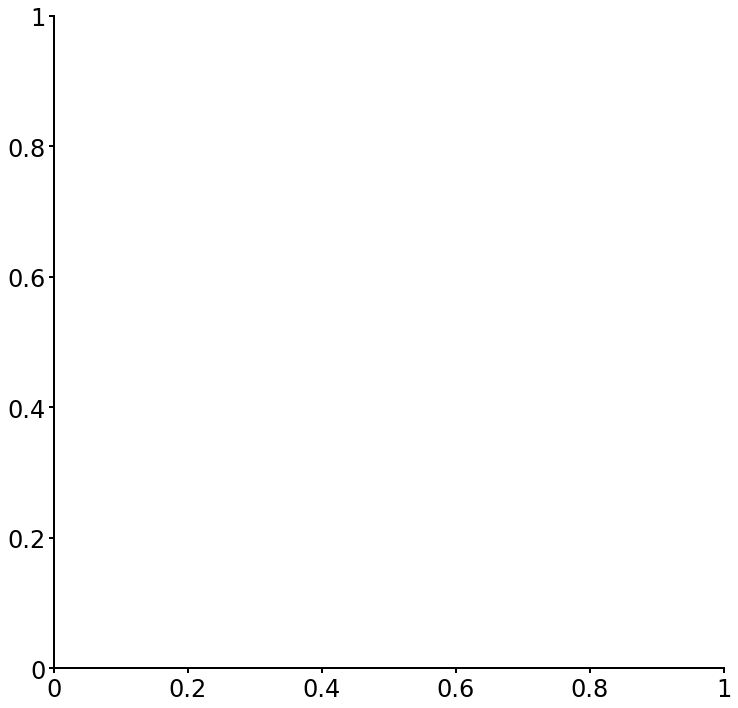

In [22]:
plot_with_stars(c1,p1,'bwr',[-1,1],'supp_figure_6B.pdf')

In [23]:
plot_with_stars(D,p3,'Greens',[0,1],'supp_figure_6A.pdf')

RuntimeError: latex was not able to process the following string:
b'$w_{\\\\text{center}}$'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (MiKTeX 2.9.7250 64-bit)
entering extended mode
(C:/Users/svo/.matplotlib/tex.cache/f7104e33373199eadccaf78426848b94.tex
LaTeX2e <2019-10-01> patch level 3
("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/latex/base\article.cls"
Document Class: article 2019/10/25 v1.4k Standard LaTeX document class
("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/latex/base\size10.clo"))
("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/latex/type1cm\type1cm.sty"
)
("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/latex/cm-super\type1ec.sty
" ("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/latex/base\t1cmr.fd"))
("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/latex/base\inputenc.sty")
("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/latex/geometry-de\geometry
.sty"
("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/latex/graphics\keyval.sty"
) ("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/generic/iftex\ifpdf.sty"
("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/generic/iftex\iftex.sty"))
 ("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/generic/iftex\ifvtex.sty"
) ("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/generic/iftex\ifxetex.st
y")
("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/latex/geometry\geometry.cf
g")

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) ("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/latex/base\textcomp.sty"
("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/latex/base\ts1enc.def"
("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/latex/base\ts1enc.dfu")))
(f7104e33373199eadccaf78426848b94.aux)
("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/latex/base\ts1cmr.fd")
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Undefined control sequence.
l.19 {\sffamily $w_{\text
                         {center}}$}
No pages of output.
Transcript written on f7104e33373199eadccaf78426848b94.log.




RuntimeError: latex was not able to process the following string:
b'$w_{\\\\text{center}}$'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (MiKTeX 2.9.7250 64-bit)
entering extended mode
(C:/Users/svo/.matplotlib/tex.cache/f7104e33373199eadccaf78426848b94.tex
LaTeX2e <2019-10-01> patch level 3
("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/latex/base\article.cls"
Document Class: article 2019/10/25 v1.4k Standard LaTeX document class
("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/latex/base\size10.clo"))
("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/latex/type1cm\type1cm.sty"
)
("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/latex/cm-super\type1ec.sty
" ("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/latex/base\t1cmr.fd"))
("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/latex/base\inputenc.sty")
("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/latex/geometry-de\geometry
.sty"
("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/latex/graphics\keyval.sty"
) ("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/generic/iftex\ifpdf.sty"
("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/generic/iftex\iftex.sty"))
 ("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/generic/iftex\ifvtex.sty"
) ("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/generic/iftex\ifxetex.st
y")
("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/latex/geometry\geometry.cf
g")

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) ("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/latex/base\textcomp.sty"
("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/latex/base\ts1enc.def"
("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/latex/base\ts1enc.dfu")))
(f7104e33373199eadccaf78426848b94.aux)
("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/latex/base\ts1cmr.fd")
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Undefined control sequence.
l.19 {\sffamily $w_{\text
                         {center}}$}
No pages of output.
Transcript written on f7104e33373199eadccaf78426848b94.log.




<Figure size 864x864 with 2 Axes>

In [24]:
def plot_param_bars(rho,sem,xlabel,c,filename=''):
    fig,ax = plt.subplots(figsize=(12,8))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax.set_xlim([0,1])
    ax.set_xlabel(xlabel,usetex=False)
    ax.barh(range(Nparams_with_lapse,0,-1), rho, xerr=sem, align='center',
        color=c, ecolor='black')
    plt.xticks(np.arange(0,1.2,0.5),usetex=False)
    plt.yticks(range(Nparams_with_lapse,0,-1),param_names_with_lapse,usetex=True, fontsize =32)
    fig.subplots_adjust(bottom=0.15,right=0.96,left=0.3,top=0.96)
    if not filename=='':
        fig.savefig(fig_direc + filename)
    plt.show()

In [25]:
param_names_with_lapse = [r'$\theta$',r'$\gamma$',r'$\delta$',r'$\lambda$',r'$C$',r'$w_{\text{center}}$',
               r'$w_{\text{connected 2-in-a-row}}$',r'$w_{\text{unconnected 2-in-a-row}}$',
              r'$w_{\text{3-in-a-row}}$',r'$w_{\text{4-in-a-row}}$']

Nparams_with_lapse = len(param_names_with_lapse)


In [26]:
P = [ave_across_splits(shrink_input(np.loadtxt(direc + 'Params/params_hvh_' + m + '.txt')))
             for m in ['final','final2']]
rho4=[sts.pearsonr(P[0][:,i],P[1][:,i])[0] for i in range(Nparams_with_lapse)]
plot_param_bars(rho4,0,'Correlation: repeated fits          ','Red','supp_figure_4A.pdf')
print(rho4,np.median(rho4))

C:\Users\svo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


RuntimeError: latex was not able to process the following string:
b'$w_{\\\\text{center}}$'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (MiKTeX 2.9.7250 64-bit)
entering extended mode
(C:/Users/svo/.matplotlib/tex.cache/f7104e33373199eadccaf78426848b94.tex
LaTeX2e <2019-10-01> patch level 3
("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/latex/base\article.cls"
Document Class: article 2019/10/25 v1.4k Standard LaTeX document class
("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/latex/base\size10.clo"))
("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/latex/type1cm\type1cm.sty"
)
("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/latex/cm-super\type1ec.sty
" ("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/latex/base\t1cmr.fd"))
("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/latex/base\inputenc.sty")
("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/latex/geometry-de\geometry
.sty"
("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/latex/graphics\keyval.sty"
) ("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/generic/iftex\ifpdf.sty"
("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/generic/iftex\iftex.sty"))
 ("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/generic/iftex\ifvtex.sty"
) ("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/generic/iftex\ifxetex.st
y")
("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/latex/geometry\geometry.cf
g")

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) ("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/latex/base\textcomp.sty"
("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/latex/base\ts1enc.def"
("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/latex/base\ts1enc.dfu")))
(f7104e33373199eadccaf78426848b94.aux)
("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/latex/base\ts1cmr.fd")
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Undefined control sequence.
l.19 {\sffamily $w_{\text
                         {center}}$}
No pages of output.
Transcript written on f7104e33373199eadccaf78426848b94.log.




RuntimeError: latex was not able to process the following string:
b'$w_{\\\\text{center}}$'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (MiKTeX 2.9.7250 64-bit)
entering extended mode
(C:/Users/svo/.matplotlib/tex.cache/f7104e33373199eadccaf78426848b94.tex
LaTeX2e <2019-10-01> patch level 3
("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/latex/base\article.cls"
Document Class: article 2019/10/25 v1.4k Standard LaTeX document class
("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/latex/base\size10.clo"))
("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/latex/type1cm\type1cm.sty"
)
("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/latex/cm-super\type1ec.sty
" ("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/latex/base\t1cmr.fd"))
("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/latex/base\inputenc.sty")
("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/latex/geometry-de\geometry
.sty"
("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/latex/graphics\keyval.sty"
) ("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/generic/iftex\ifpdf.sty"
("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/generic/iftex\iftex.sty"))
 ("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/generic/iftex\ifvtex.sty"
) ("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/generic/iftex\ifxetex.st
y")
("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/latex/geometry\geometry.cf
g")

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) ("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/latex/base\textcomp.sty"
("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/latex/base\ts1enc.def"
("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/latex/base\ts1enc.dfu")))
(f7104e33373199eadccaf78426848b94.aux)
("C:\Users\svo\AppData\Local\Programs\MiKTeX 2.9\tex/latex/base\ts1cmr.fd")
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Undefined control sequence.
l.19 {\sffamily $w_{\text
                         {center}}$}
No pages of output.
Transcript written on f7104e33373199eadccaf78426848b94.log.




<Figure size 864x576 with 1 Axes>

In [18]:
P=np.vstack([shrink_input(np.loadtxt(direc + 'Params/params_' + e + '_final.txt')) 
             for e in ['hvh','learn','tai','gen','eye']])
P=np.reshape(P,[-1,5,10])
p1=[sts.ttest_1samp(np.corrcoef(P[:,:,i].T)[np.triu_indices(5,1)],popmean=0).pvalue 
    for i in range(10)]
rho1=[np.nanmean(np.corrcoef(P[:,:,i].T)[np.triu_indices(5,1)]) for i in range(10)]
sem1=[np.nanstd(np.corrcoef(P[:,:,i].T)[np.triu_indices(5,1)])/np.sqrt(10) for i in range(10)]
plot_param_bars(rho1,sem1,'Correlation: splits','C0')

C:\Users\svo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


NameError: name 'plot_param_bars' is not defined

In [19]:
#correlations across learning sessions 
P=ave_across_splits(shrink_input(np.loadtxt(direc + 'Params/params_learn_final.txt')))
rho2 = [np.mean(np.hstack([[sts.pearsonr(P[n::5,i],P[m::5,i])[0] for m in range(n)] for n in range(5)])) for i in range(10)]
sem2 = [np.std(np.hstack([[sts.pearsonr(P[n::5,i],P[m::5,i])[0]/np.sqrt(10) for m in range(n)] for n in range(5)])) for i in range(10)]
p2 = [sts.ttest_1samp(np.hstack([[sts.pearsonr(P[n::5,i],P[m::5,i])[0] for m in range(n)] for n in range(5)]),popmean=0) for i in range(10)]
plot_param_bars(rho2,sem2,'Correlation: learning    ',learn_colors[2],'supp_figure_4B.pdf')

C:\Users\svo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


NameError: name 'plot_param_bars' is not defined

In [20]:
#correlations across learning sessions 
P=ave_across_splits(shrink_input(np.loadtxt(direc + 'Params/params_tai_final.txt')))
rho2 = [np.mean(np.hstack([[sts.pearsonr(P[n::3,i],P[m::3,i])[0] for m in range(n)] for n in range(3)])) for i in range(10)]
sem2 = [np.std(np.hstack([[sts.pearsonr(P[n::3,i],P[m::3,i])[0]/np.sqrt(10) for m in range(n)] for n in range(3)])) for i in range(10)]
p2 = [sts.ttest_1samp(np.hstack([[sts.pearsonr(P[n::3,i],P[m::3,i])[0] for m in range(n)] for n in range(3)]),popmean=0).pvalue for i in range(10)]
plot_param_bars(rho2,sem2,'Correlation: time constraints',time_colors[1])

C:\Users\svo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


NameError: name 'plot_param_bars' is not defined